# Simple Neural Network Model with different inputs

Input: testing different inputs

Output: optimal max-shape portfolio with normal restrictions for the next period

## Data Pre-processing

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [35]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.regularizers import L2

from helper_functions import train_and_evaluate_model

In [36]:
import os
os.chdir(os.path.expanduser('../data'))

from dotenv import load_dotenv
load_dotenv()

from DataProvider import DataProvider

In [37]:
data_provider = DataProvider()

df_countries, benchmark = data_provider.get_etf_data()
acwi_weights = data_provider.get_acwi_weights()

In [38]:
days_to_recalculate = data_provider.get_days_to_recalculate()

# Start after 1 year to have enough historic data for first calculated period
days_to_recalculate = days_to_recalculate.iloc[12:]
days_to_recalculate = pd.DatetimeIndex(days_to_recalculate)
days_to_recalculate

DatetimeIndex(['2000-01-04', '2000-02-04', '2000-03-06', '2000-04-04',
               '2000-05-04', '2000-06-06', '2000-07-05', '2000-08-04',
               '2000-09-06', '2000-10-04',
               ...
               '2023-03-03', '2023-04-06', '2023-05-04', '2023-06-06',
               '2023-07-06', '2023-08-03', '2023-09-06', '2023-10-05',
               '2023-11-03', '2023-12-05'],
              dtype='datetime64[ns]', name='Days to rebalance', length=288, freq=None)

Preparing outputs common for all models

In [39]:
os.chdir(os.path.expanduser('../optimization'))

from PortfolioOptimizer import PortfolioOptimizer

In [40]:
y = []
for i in range(0,len(days_to_recalculate)):
    if i == len(days_to_recalculate) - 1:
        data_period = df_countries.loc[
            days_to_recalculate[i]:]
    else:
        data_period = df_countries.loc[
            days_to_recalculate[i]:days_to_recalculate[i+1]]
    i += 1

    year_str = str(data_period.index[0].year)
    acwi_weights_year = acwi_weights.loc[year_str]

    optimizer = PortfolioOptimizer()
    w, constraints = optimizer.get_normal_constraints(acwi_weights_year)
    optimal_portfolio = optimizer.get_optimal_portfolio(
        data_period, w, constraints)
    y.append(optimal_portfolio.values)

y = np.array(y)
y.shape

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


(288, 27)

In [41]:
val_split = int(0.7 * y.shape[0])
test_split = int(0.8 * y.shape[0])

# Train
dates_for_training = days_to_recalculate[:val_split]
y_train = y[:val_split]

# Validation
dates_for_validation = days_to_recalculate[val_split:test_split]
y_val = y[val_split:test_split]

# Test
dates_for_test = days_to_recalculate[test_split:]
y_test = y[test_split:]

In [42]:
os.chdir(os.path.expanduser('../data'))

## Defining models for different inputs

### DNN Model with a single fixed weight composite indicators

In [43]:
x = []
for date in days_to_recalculate:
    indicators = data_provider.calculate_simple_composite_indicator(
        date, periods=6)
    x.append(indicators.values)

x_simple_composite_indicator = np.array(x)

x_train_simple_composite_indicator = x_simple_composite_indicator[:val_split]
x_val_simple_composite_indicator = x_simple_composite_indicator[val_split:test_split]
x_test_simple_composite_indicator = x_simple_composite_indicator[test_split:]

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 162)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │         2,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 27)             │           459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,067 (11.98 KB)

 Trainable params: 3,067 (11.98 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.8803 - val_loss: 2.6392 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.5640 - val_loss: 2.3435 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.2751 - val_loss: 2.0750 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0133 - val_loss: 1.8329 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7770 - val_loss: 1.6156 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5652 - val_loss: 1.4215 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3766 - val_loss: 1.2486 - learning_rate: 0.0010
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2085 - val_loss: 1.0948 - learning_rate: 0.0010
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0594 - val_loss: 0.9584 - learning_rate: 0.0010
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━

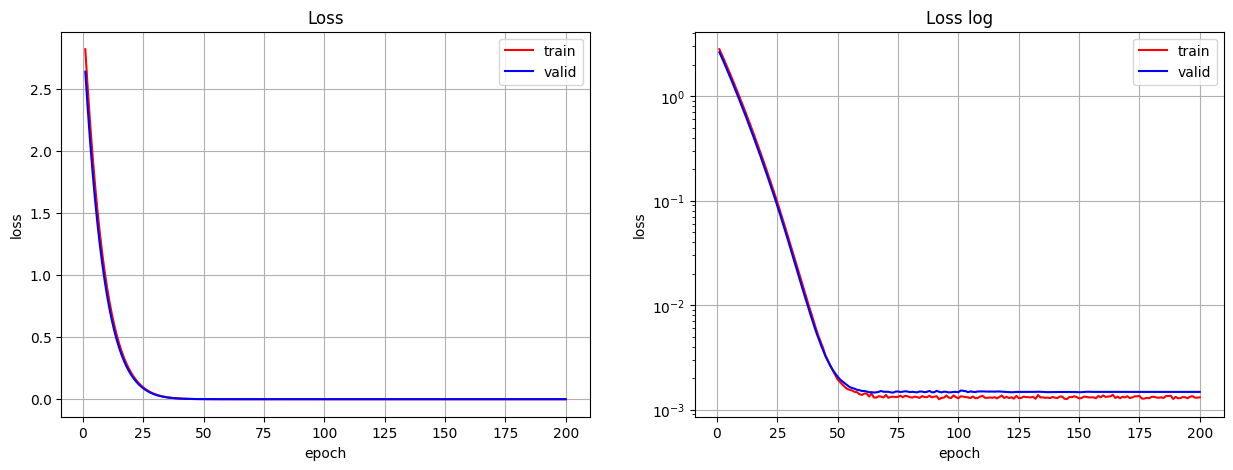

In [44]:
model_dnn_simple_composite_indicator = Sequential((
    Flatten(input_shape=x_train_simple_composite_indicator.shape[1:]),
    Dense(16, activation='relu', kernel_regularizer=L2(0.1)),
    Dense(y_train.shape[1], activation='softmax')
))

train_and_evaluate_model(model_dnn_simple_composite_indicator, 
                         x_train_simple_composite_indicator, y_train,
                         x_val_simple_composite_indicator, y_val, 
                         x_test_simple_composite_indicator, y_test)

### DNN Model with a single Manufacturing PMI indicator

In [45]:
indicator = 'Manufacturing PMI'
x = []
for date in days_to_recalculate:
    df = data_provider.get_key_indicator_values(indicator)
    df_normalized = data_provider.normilize_dataframe(df)
    df_last_values = data_provider.get_latest_data(
        indicator, df_normalized, date, periods=6)
    x.append(df_last_values.values)

x_manufacturing_pmi = np.array(x)

x_train_manufacturing_pmi = x_manufacturing_pmi[:val_split]
x_val_manufacturing_pmi = x_manufacturing_pmi[val_split:test_split]
x_test_manufacturing_pmi = x_manufacturing_pmi[test_split:]

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)             │ (None, 162)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │         2,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 27)             │           459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,067 (11.98 KB)

 Trainable params: 3,067 (11.98 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.7864 - val_loss: 2.5515 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4780 - val_loss: 2.2632 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.1959 - val_loss: 2.0019 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9412 - val_loss: 1.7668 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7121 - val_loss: 1.5563 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5076 - val_loss: 1.3687 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3251 - val_loss: 1.2018 - learning_rate: 0.0010
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1627 - val_loss: 1.0537 - learning_rate: 0.0010
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0189 - val_loss: 0.9226 - learning_rate: 0.0010
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━

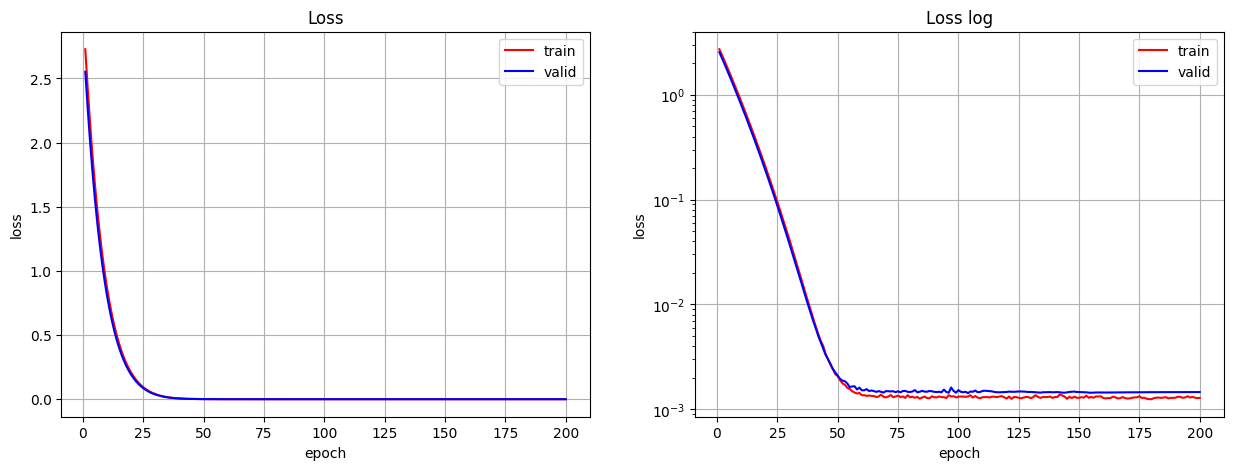

In [46]:
model_dnn_manufacturing_pmi = Sequential((
    Flatten(input_shape=x_train_manufacturing_pmi.shape[1:]),
    Dense(16, activation='relu', kernel_regularizer=L2(0.1)),
    Dense(y_train.shape[1], activation='softmax')
))

train_and_evaluate_model(model_dnn_manufacturing_pmi, 
                         x_train_manufacturing_pmi, y_train,
                         x_val_manufacturing_pmi, y_val, 
                         x_test_manufacturing_pmi, y_test)

### DNN Model with 6 separate indicators

In [47]:
x = []
for date in days_to_recalculate:
    indicators_arr = []
    for indicator in data_provider.key_indicators:
        df = data_provider.get_key_indicator_values(indicator)
        df_normalized = data_provider.normilize_dataframe(df)
        indicators_arr.append(data_provider.get_latest_data(
            indicator, df_normalized, date, periods=6).values)

    concat_indicators = np.concatenate(indicators_arr, axis=1)
    x.append(concat_indicators)

x_separate_indicators = np.array(x)

x_train_separate_indicators = x_separate_indicators[:val_split]
x_val_separate_indicators = x_separate_indicators[val_split:test_split]
x_test_separate_indicators = x_separate_indicators[test_split:]

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_6 (Flatten)             │ (None, 972)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │        15,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 27)             │           459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,027 (62.61 KB)

 Trainable params: 16,027 (62.61 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.0044 - val_loss: 2.4242 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.2617 - val_loss: 1.7953 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6670 - val_loss: 1.3030 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2038 - val_loss: 0.9279 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8532 - val_loss: 0.6491 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5940 - val_loss: 0.4465 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4068 - val_loss: 0.3022 - learning_rate: 0.0010
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2736 - val_loss: 0.2015 - learning_rate: 0.0010
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1815 - val_loss: 0.1325 - learning_rate: 0.0010
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━

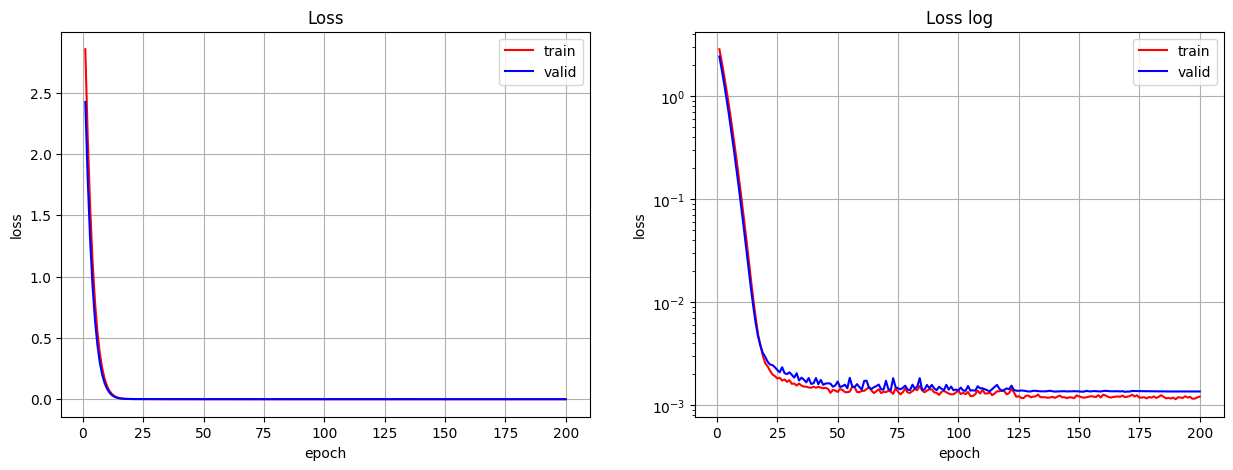

In [48]:
model_dnn_separate_indicators = Sequential((
    Flatten(input_shape=x_train_separate_indicators.shape[1:]),
    Dense(16, activation='relu', kernel_regularizer=L2(0.1)),
    Dense(y_train.shape[1], activation='softmax')
))

train_and_evaluate_model(model_dnn_separate_indicators, 
                         x_train_separate_indicators, y_train,
                         x_val_separate_indicators, y_val, 
                         x_test_separate_indicators, y_test)

### DNN Model with single principal component from PCA

In [60]:
x = []
for date in days_to_recalculate:
    indicators = data_provider.calculate_principal_component_from_indicators(
        date, periods=6)
    x.append(indicators.values)

x_pca_component = np.array(x)

x_train_pca_component = x_pca_component[:val_split]
x_val_pca_component = x_pca_component[val_split:test_split]
x_test_pca_component = x_pca_component[test_split:]

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_8 (Flatten)             │ (None, 162)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 16)             │         2,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 27)             │           459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,067 (11.98 KB)

 Trainable params: 3,067 (11.98 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.7908 - val_loss: 2.5548 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4803 - val_loss: 2.2652 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1972 - val_loss: 2.0027 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9411 - val_loss: 1.7665 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7110 - val_loss: 1.5552 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5057 - val_loss: 1.3669 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3222 - val_loss: 1.1995 - learning_rate: 0.0010
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1596 - val_loss: 1.0511 - learning_rate: 0.0010
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0155 - val_loss: 0.9197 - learning_rate: 0.0010
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━

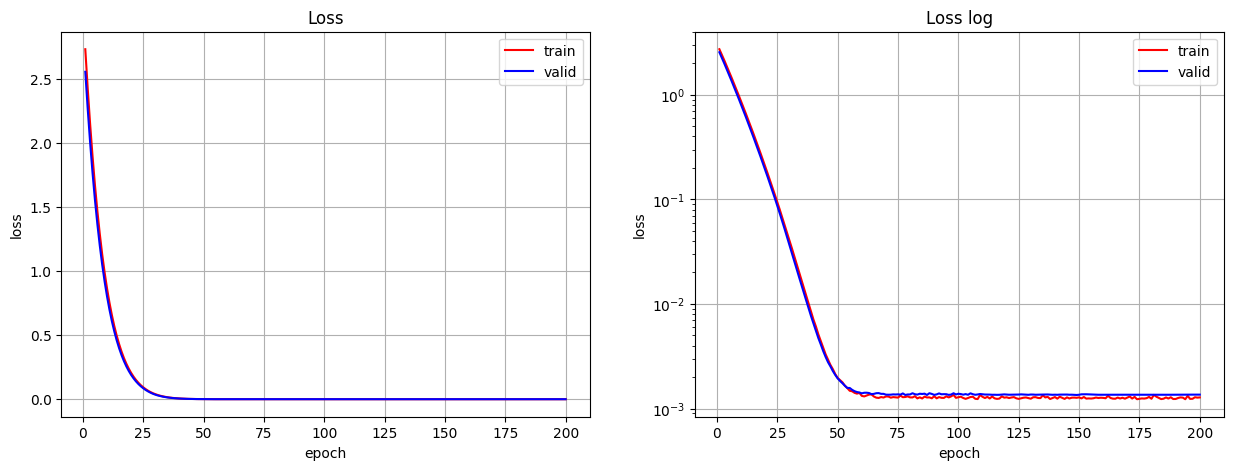

In [61]:
model_dnn_pca_component = Sequential((
    Flatten(input_shape=x_train_pca_component.shape[1:]),
    Dense(16, activation='relu', kernel_regularizer=L2(0.1)),
    Dense(y_train.shape[1], activation='softmax')
))

train_and_evaluate_model(model_dnn_pca_component, 
                         x_train_pca_component, y_train,
                         x_val_pca_component, y_val, 
                         x_test_pca_component, y_test)

## Backtesting

In [62]:
from helper_functions import calculate_returns_for_model, calculate_metrics

In [63]:
benchmark_test = benchmark[dates_for_test[0]:]
benchmark_returns = np.log(benchmark_test).diff().dropna()
cum_benchmark_returns = (1 + benchmark_returns).cumprod() - 1
cum_benchmark_returns.loc[dates_for_test[0]] = 0
cum_benchmark_returns.sort_index(inplace=True)

In [64]:
selected_countries = df_countries.columns
days_to_rebalance = dates_for_test.insert(29, df_countries.index.values[-1])
df_prices_test = df_countries[dates_for_test[0]:]
df_returns_test = np.log(df_prices_test).diff().fillna(0)

In [65]:
(total_ret_simple_composite_indicator,
 cum_total_ret_simple_composite_indicator) = calculate_returns_for_model(
    model_dnn_simple_composite_indicator, x_test_simple_composite_indicator,
    dates_for_test, df_returns_test, selected_countries)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [66]:
(total_ret_manufacturing_pmi, 
 cum_total_ret_manufacturing_pmi) = calculate_returns_for_model(
    model_dnn_manufacturing_pmi, x_test_manufacturing_pmi,
    dates_for_test, df_returns_test, selected_countries)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


In [67]:
(total_ret_separate_indicators, 
 cum_total_ret_separate_indicators) = calculate_returns_for_model(
    model_dnn_separate_indicators, x_test_separate_indicators,
    dates_for_test, df_returns_test, selected_countries)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step 


In [68]:
(total_ret_pca_component, 
 cum_total_ret_pca_component) = calculate_returns_for_model(
    model_dnn_pca_component, x_test_pca_component,
    dates_for_test, df_returns_test, selected_countries)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


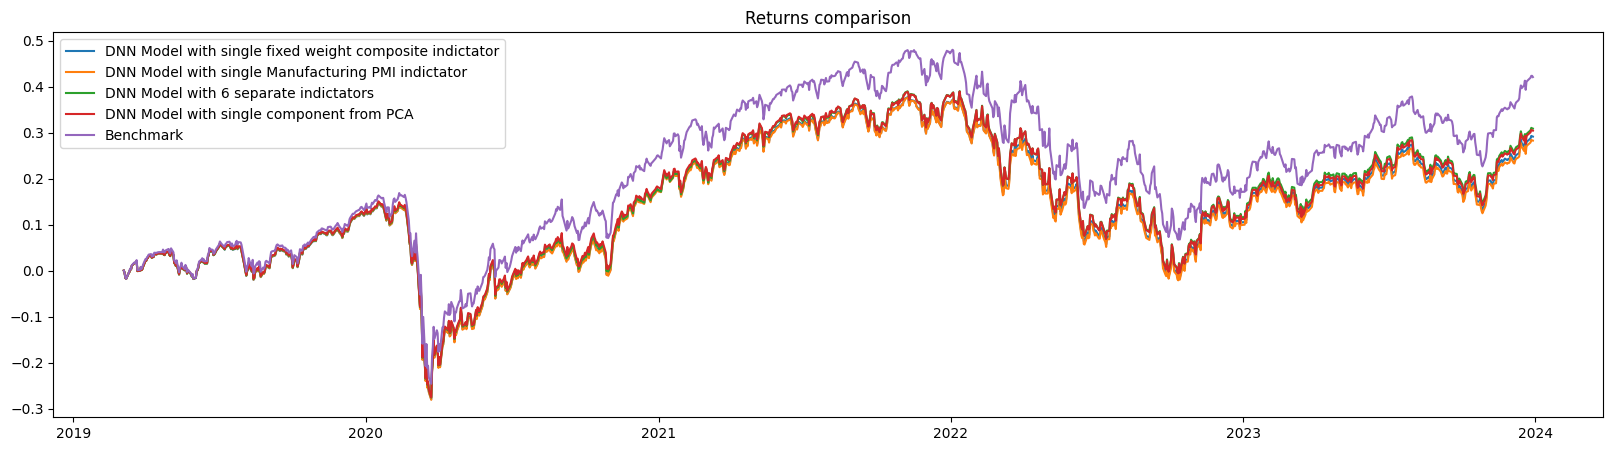

In [69]:
plt.figure(figsize=(20, 5))
plt.plot(cum_total_ret_simple_composite_indicator,
         label='DNN Model with single fixed weight composite indictator')
plt.plot(cum_total_ret_manufacturing_pmi,
         label='DNN Model with single Manufacturing PMI indictator')
plt.plot(cum_total_ret_separate_indicators,
         label='DNN Model with 6 separate indictators')
plt.plot(cum_total_ret_pca_component,
         label='DNN Model with single component from PCA')
plt.plot(cum_benchmark_returns, label='Benchmark')
plt.legend()
plt.title('Returns comparison')
plt.show()

In [70]:
df_results = pd.DataFrame(columns=['Annual Returns',
                                   'Annual Volatility',
                                   'Annual Sharpe Ratio'])

calculate_metrics(benchmark_returns, df_results, 'Benchmark')
calculate_metrics(total_ret_simple_composite_indicator, df_results,
                  'DNN Model with single fixed weight composite indictator')
calculate_metrics(total_ret_manufacturing_pmi, df_results,
                  'DNN Model with single Manufacturing PMI indictator')
calculate_metrics(total_ret_separate_indicators, df_results,
                  'DNN Model with 6 separate indictators')
calculate_metrics(total_ret_pca_component, df_results,
                  'DNN Model with single component from PCA')

df_results

,Annual Returns,Annual Volatility,Annual Sharpe Ratio
Benchmark,0.076754,0.203326,0.377494
DNN Model with single fixed weight composite indictator,0.054491,0.201149,0.270899
DNN Model with single Manufacturing PMI indictator,0.053015,0.201251,0.263428
DNN Model with 6 separate indictators,0.057429,0.200912,0.285842
DNN Model with single component from PCA,0.056678,0.201065,0.281887
